# Tracking stage

This notebook contains the implementation of the Hungarian Algorithm for the data assingment problem. It has been adapted to track the buildings in the context of the project Multi-target building tracking. 

Due to the considerable computational time, the solution is presented here for a small area as well. Likewise, the tracking is done over the results of segmentation and over the ground truth. In the second case it is done just to show that the algorithm works well. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from skimage import measure
from scipy.optimize import linear_sum_assignment

In [2]:
def extract_footprints(img, show):
  contours = measure.find_contours(img, 0.8)

  if show == True:
    fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
    ax.imshow(img, cmap=plt.cm.gray)

    for contour in contours:
      ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
  return contours

def isolate_footprints(contour1, contour2):
  x1 = contour1[:,1]
  y1 = contour1[:,0]

  x2 = contour2[:,1]
  y2 = contour2[:,0]

  min_x = min(np.min(x1), np.min(x2))
  min_y = min(np.min(y1), np.min(y2))

  x1 = x1-min_x
  y1 = y1-min_y

  x2 = x2-min_x
  y2 = y2-min_y

  max_x = max(np.max(x1), np.max(x2))
  max_y = max(np.max(y1), np.max(y2))

  reg_shape = (np.ceil(max_x).astype('int'), np.ceil(max_y).astype('int'))

  polygon1 = list(zip(x1, y1))
  polygon2 = list(zip(x2, y2))

  img_out1 = Image.new('L', reg_shape, 0)
  ImageDraw.Draw(img_out1).polygon(polygon1, outline=1, fill=1) #outline=0
  mask1 = np.array(img_out1)

  img_out2 = Image.new('L', reg_shape, 0)
  ImageDraw.Draw(img_out2).polygon(polygon2, outline=1, fill=1) #outline=0
  mask2 = np.array(img_out2)
  
  return mask1, mask2

def compute_iou(mask1, mask2):

  epsilon = 1e-6

  intersection = np.sum(mask1 & mask2)
  # To avoid more computations
  if intersection == 0:
    return 0

  union = np.sum(mask1 | mask2)
    
  iou = (intersection + epsilon) / (union + epsilon)
  return iou 


def in_neighborhood(contour1, contour2, img_shape, area):
  
  xmax1 = min(np.max(contour1[:,1])+area, img_shape[1])
  xmin1 = max(np.min(contour1[:,1])-area, 0)
  ymax1 = min(np.max(contour1[:,0])+area, img_shape[0])
  ymin1 = max(np.min(contour1[:,0])-area, 0)

  xmax2 = min(np.max(contour2[:,1])+area, img_shape[1])
  xmin2 = max(np.min(contour2[:,1])-area, 0)
  ymax2 = min(np.max(contour2[:,0])+area, img_shape[0])
  ymin2 = max(np.min(contour2[:,0])-area, 0)
  

  R1 = [xmin1, ymax1, xmax1, ymin1]
  R2 = [xmin2, ymax2, xmax2, ymin2]
  
  if (R1[0]>=R2[2]) or (R1[2]<=R2[0]) or (R1[3]>=R2[1]) or (R1[1]<=R2[3]):
    return False
  else:
    return True

def compute_costmat(contours1, contours2, region1, region2):
  iou_mat = np.zeros((len(contours1), len(contours2)))
  for idx0, contour_0 in enumerate(contours1):
    for idx1, contour_1 in enumerate(contours2):
      if in_neighborhood(contour_0, contour_1, region1.shape, area=0):
        mask_0, mask_1 = isolate_footprints(contour_0, contour_1)
        iou_mat[idx0,idx1] = compute_iou(mask_0, mask_1)
      
  cost_mat = np.ones((len(contours1), len(contours2))) - iou_mat
  return cost_mat

def propagate_labels(labels, labels_old, len_new):
  #Assign ids old to new detections (-1) if there's no correspondence
  id_new = np.zeros((len_new))  
  for i in range(len(id_new)):
    try:
      id_new[i] = labels_old[np.where(labels == i)[0][0]]
    except:
      id_new[i] = -1
  
  # Assign new id to those detections that don't have correspondence
  count = len(labels_old)
  for idx, i in enumerate(id_new):
    if i == -1:
      id_new[idx] = count
      count += 1
  
  return id_new

def plot_tracking(contours, labels, region, fig_size):
  fig, ax = plt.subplots(figsize=fig_size, dpi=80)
  ax.imshow(region, cmap=plt.cm.gray)

  for i, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    ax.text(contour[0, 1], contour[0, 0], str(round(labels[i])),verticalalignment='top', color='red',fontsize=10,weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
  plt.show()

In [3]:
def track_buildings(img_0, img_1, labels_old, fig_size):
  conts_pred0 = extract_footprints(img_0, False)
  conts_pred1 = extract_footprints(img_1, False)
  cost_mat = compute_costmat(conts_pred0, conts_pred1, img_0, img_1)
  _, index = linear_sum_assignment(cost_mat)

  # First time step
  if labels_old is None:
    #labels_old = range(len(conts_pred0))
    labels_old = np.arange(len(conts_pred0))
    plot_tracking(conts_pred0, labels_old, img_0, fig_size)

  labels_new = propagate_labels(index, labels_old, len(conts_pred1))
  plot_tracking(conts_pred1, labels_new, img_1, fig_size)

  return labels_old, conts_pred0, labels_new, conts_pred1

# Test over small area

### Test over the result of segmentation

In [ ]:
img_pred0 = Image.open('/content/Pred_0.png')
r_pred0 = np.array(img_pred0)
r_pred0 = r_pred0[:100,:100,0]
r_pred0 = np.where(r_pred0>100, 255, 0)

img_pred1 = Image.open('/content/Pred_1.png')
r_pred1 = np.array(img_pred1)
r_pred1 = r_pred1[:100,:100,0]
r_pred1 = np.where(r_pred1>100, 255, 0)

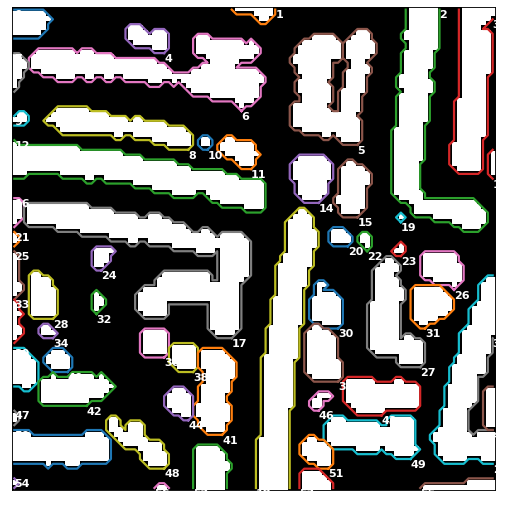

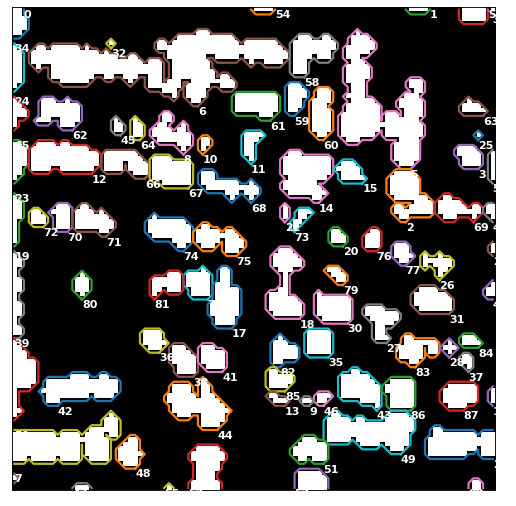

In [ ]:
labels_old, conts_pred0, labels_new, conts_pred1 = track_buildings(r_pred0, r_pred1, None, fig_size=(8,8))

### Test over the ground truth to check tracking only

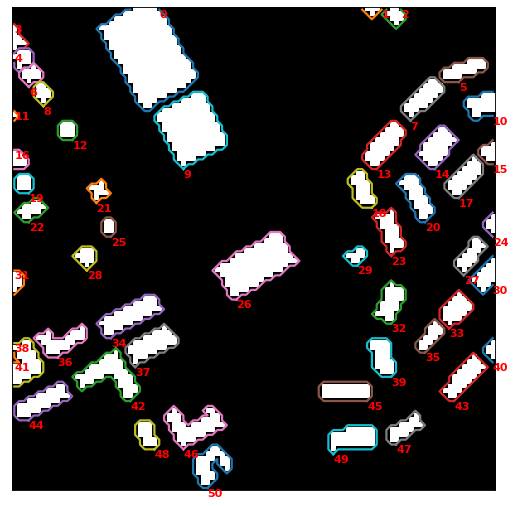

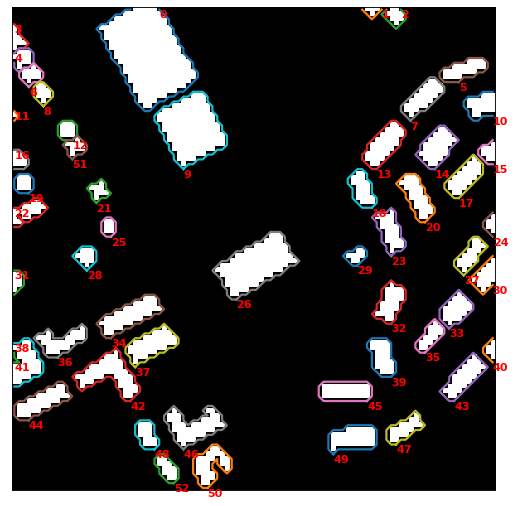

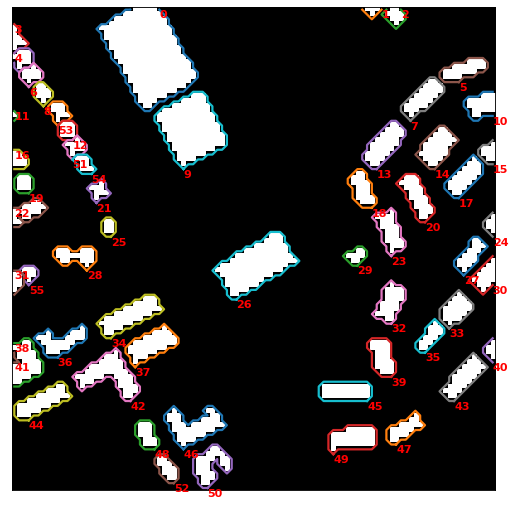

In [4]:
#Note: the region considered is different than in the segmentation (see r_true0)
#because in the other region there is no change for the GT

img_true0 = Image.open('/content/True_29.png')
r_true0 = np.array(img_true0)
r_true0 = r_true0[200:300,200:300,0]
r_true0 = np.where(r_true0>100, 255, 0)

img_true1 = Image.open('/content/True_30.png')
r_true1 = np.array(img_true1)
r_true1 = r_true1[200:300,200:300,0]
r_true1 = np.where(r_true1>100, 255, 0)

img_true2 = Image.open('/content/True_31.png')
r_true2 = np.array(img_true2)
r_true2 = r_true2[200:300,200:300,0]
r_true2 = np.where(r_true2>100, 255, 0)

labels_true0, conts_true0, labels_true1, conts_true1 = track_buildings(r_true0, r_true1, None, fig_size=(8,8))
labels_true1, conts_true1, labels_true2, conts_true2 = track_buildings(r_true1, r_true2, labels_true1, fig_size=(8,8))

# Test over the entire image

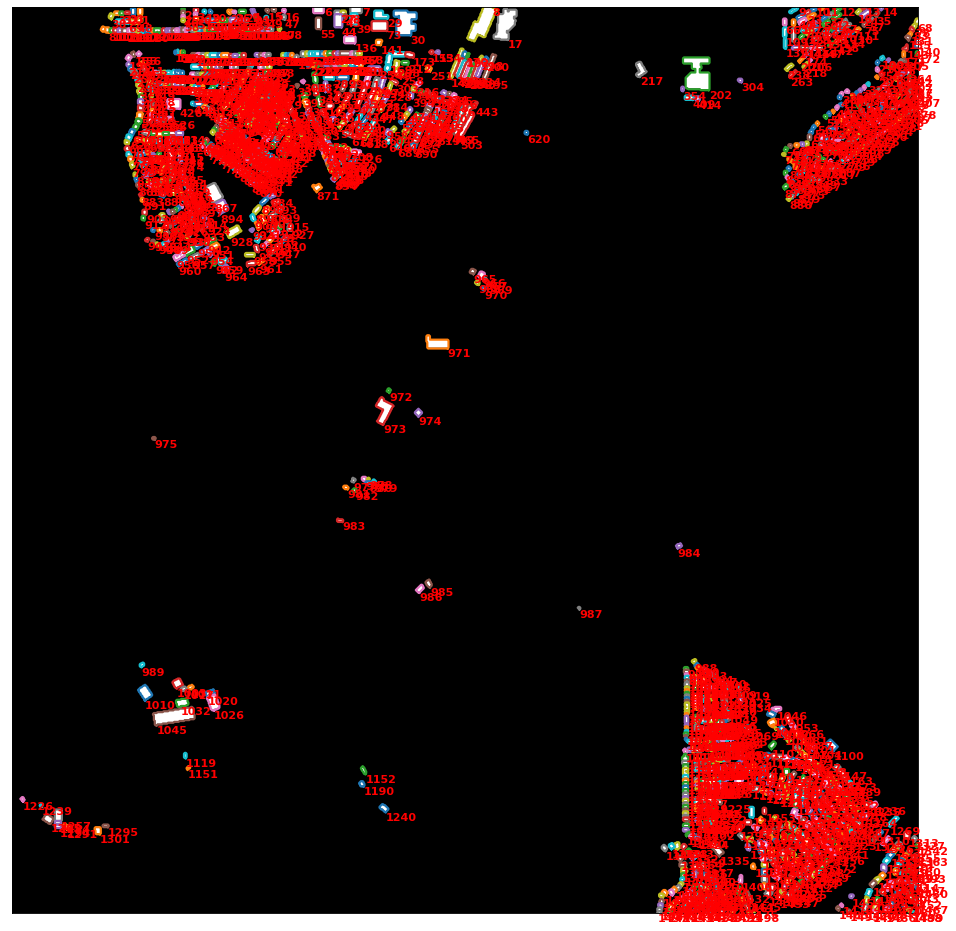

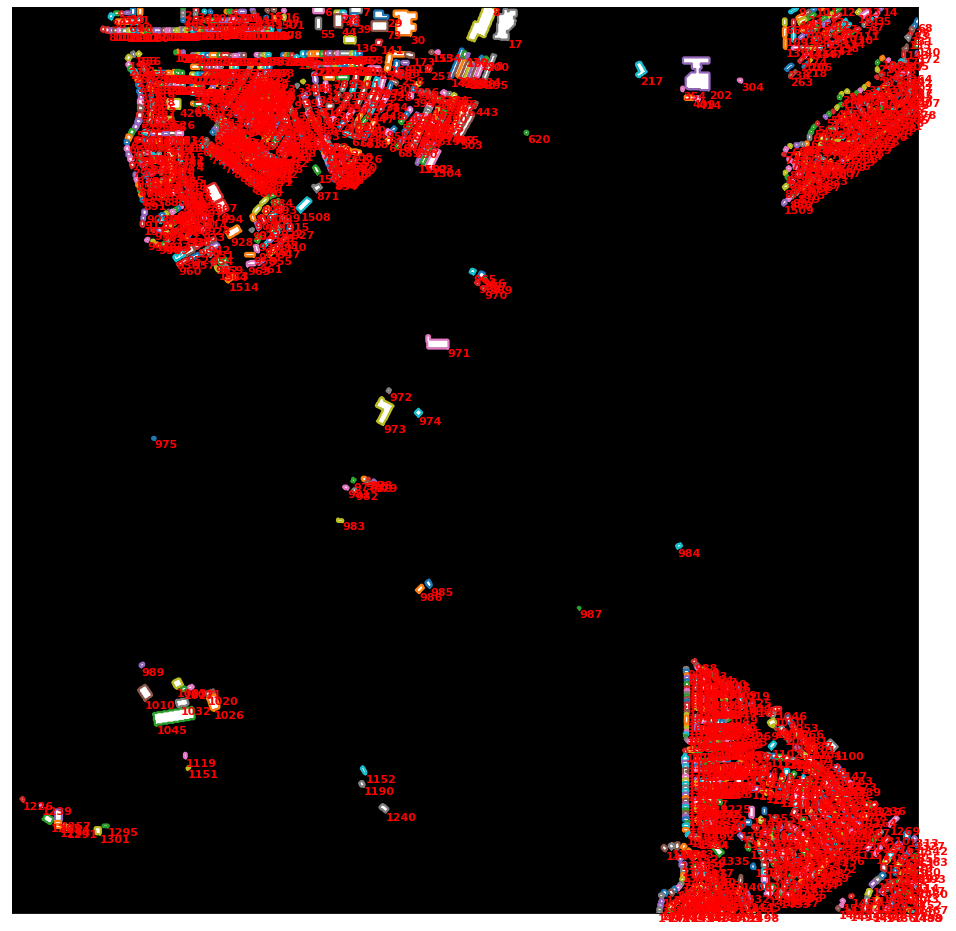

In [6]:
img_true0 = Image.open('/content/True_29.png')
r_true0 = np.array(img_true0)
r_true0 = r_true0[:,:,0]
r_true0 = np.where(r_true0>100, 255, 0)

img_true1 = Image.open('/content/True_30.png')
r_true1 = np.array(img_true1)
r_true1 = r_true1[:,:,0]
r_true1 = np.where(r_true1>100, 255, 0)

labels_true0, conts_true0, labels_true1, conts_true1 = track_buildings(r_true0, r_true1, None, fig_size=(15,15))